In [1]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import json
import os



2025-01-19 11:57:42.625393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-19 11:57:42.625782: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 11:57:42.628073: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-19 11:57:42.633409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737284262.642263   25675 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737284262.64

In [2]:

# Charger le modèle DenseNet121 pré-entraîné avec les poids d'ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


2025-01-19 11:57:44.115161: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
dataset_path = 'Dataset'
output_image_size = (224, 224)  # Taille des images (hauteur, largeur)
batch_size = 32  # Taille des batchs

In [4]:

# Ajouter des couches personnalisées
custom_layers = base_model.output
custom_layers = GlobalAveragePooling2D()(custom_layers)  # Pooling global pour réduire les dimensions
custom_layers = Dense(1024, activation='relu')(custom_layers)  # Couche dense avec 1024 neurones
custom_layers = Dropout(0.5)(custom_layers)  # Dropout pour réduire le surapprentissage
custom_layers = Dense(512, activation='relu')(custom_layers)  # Une autre couche dense
custom_layers = Dropout(0.5)(custom_layers)  # Second Dropout
predictions = Dense(151, activation='softmax')(custom_layers)  # Couche de sortie avec 151 classes


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalisation des pixels entre 0 et 1
    rotation_range=20,  # Rotation aléatoire jusqu'à 20 degrés
    width_shift_range=0.2,  # Décalage horizontal jusqu'à 20%
    height_shift_range=0.2,  # Décalage vertical jusqu'à 20%
    shear_range=0.2,  # Cisaillement aléatoire
    zoom_range=0.2,  # Zoom aléatoire
    horizontal_flip=True,  # Flip horizontal
    validation_split=0.2  # Fraction des données pour validation
)


In [6]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=output_image_size,
    batch_size=batch_size,
    class_mode='categorical',  # 'categorical' pour classification multi-classes
    subset='training'  # Sous-ensemble d'entraînement
)


Found 13194 images belonging to 151 classes.


In [7]:
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=output_image_size,
    batch_size=batch_size,
    class_mode='categorical',  # 'categorical' pour classification multi-classes
    subset='validation'  # Sous-ensemble de validation
)


Found 3216 images belonging to 151 classes.


In [8]:

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=predictions)


In [9]:
from tqdm.auto import tqdm
import os
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
import json
import tensorflow as tf

def train_DenseNet121(model, train_generator, validation_generator, epochs=20, learning_rate=0.0001, checkpoint_dir='checkpoints'):
    """
    Entraîne et évalue un modèle DenseNet121 avec une barre de progression.
    Args:
        model: Modèle DenseNet121 personnalisé.
        train_generator: Générateur de données d'entraînement.
        validation_generator: Générateur de données de validation.
        epochs: Nombre d'époques pour l'entraînement.
        learning_rate: Taux d'apprentissage pour l'optimiseur Adam.
        checkpoint_dir: Répertoire pour sauvegarder les checkpoints.
    Returns:
        history: Historique de l'entraînement.
    """
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    metrics_file = os.path.join(checkpoint_dir, 'training_metrics.json')
    checkpoint_file = os.path.join(checkpoint_dir, 'best_model.h5')

    # Calcul des poids des classes
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_generator.classes),
        y=train_generator.classes
    )
    class_weights = dict(enumerate(class_weights))
    print("Class weights :", class_weights)

    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\n=== Début de l'entraînement du modèle DenseNet121 ===\n")
    
    best_val_acc = 0
    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    
    # Créer un itérateur tqdm pour les époques
    epoch_iterator = tqdm(range(epochs), desc="Epochs", position=0)
    
    for epoch in epoch_iterator:
        # Calculer le nombre total de batchs
        total_batches = len(train_generator)
        
        # Créer un callback personnalisé pour mettre à jour la barre de progression
        class ProgressCallback(tf.keras.callbacks.Callback):
            def __init__(self):
                super(ProgressCallback, self).__init__()
                self.progress_bar = tqdm(total=total_batches, 
                                       desc=f"Epoch {epoch+1}/{epochs}",
                                       position=1, 
                                       leave=False)
                
            def on_batch_end(self, batch, logs=None):
                self.progress_bar.update(1)
                self.progress_bar.set_postfix({
                    'loss': f"{logs['loss']:.4f}",
                    'acc': f"{logs['accuracy']:.4f}"
                })
                
            def on_epoch_end(self, epoch, logs=None):
                self.progress_bar.close()

        # Entraînement avec la barre de progression
        train_history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=1,
            class_weight=class_weights,
            verbose=0,  # Désactiver la sortie par défaut
            callbacks=[ProgressCallback()]
        )

        # Mise à jour de l'historique
        history['loss'].append(train_history.history['loss'][0])
        history['accuracy'].append(train_history.history['accuracy'][0])
        history['val_loss'].append(train_history.history['val_loss'][0])
        history['val_accuracy'].append(train_history.history['val_accuracy'][0])

        # Mise à jour de la barre de progression principale
        epoch_iterator.set_postfix({
            'val_acc': f"{train_history.history['val_accuracy'][0]:.4f}",
            'val_loss': f"{train_history.history['val_loss'][0]:.4f}"
        })

        # Sauvegarde du meilleur modèle
        val_acc = train_history.history['val_accuracy'][0]
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model.save(checkpoint_file)
            print(f"\nNew best model saved with validation accuracy: {val_acc:.2f}% at epoch {epoch+1}")

        # Sauvegarde des métriques
        with open(metrics_file, 'w') as f:
            json.dump(history, f)

    print("\n=== Fin de l'entraînement ===\n")
    return history

/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:

# Appel de la fonction d'entraînement
history = train_DenseNet121(model, train_generator, validation_generator, epochs=20, learning_rate=0.0001)


Class weights : {0: np.float64(1.820364238410596), 1: np.float64(1.016017249345449), 2: np.float64(1.5886815171583384), 3: np.float64(0.9708609271523179), 4: np.float64(0.7801561021759698), 5: np.float64(0.8737748344370861), 6: np.float64(0.8737748344370861), 7: np.float64(0.9497552548229197), 8: np.float64(0.8483250819777535), 9: np.float64(0.5984759139980041), 10: np.float64(0.6934720908230843), 11: np.float64(0.8166119948010151), 12: np.float64(0.910182119205298), 13: np.float64(1.0402081362346263), 14: np.float64(0.7103860442577936), 15: np.float64(0.8737748344370861), 16: np.float64(1.1202241467142129), 17: np.float64(1.2306687808973042), 18: np.float64(1.2135761589403973), 19: np.float64(0.740487147828039), 20: np.float64(1.0922185430463576), 21: np.float64(1.2849629918192442), 22: np.float64(1.2849629918192442), 23: np.float64(1.1650331125827815), 24: np.float64(1.4324177613722724), 25: np.float64(1.0402081362346263), 26: np.float64(0.891606973915394), 27: np.float64(1.120224146

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epochs:   5%|▌         | 1/20 [16:21<5:10:46, 981.38s/it, val_acc=0.5504, val_loss=2.5416]


New best model saved with validation accuracy: 0.55% at epoch 1


Epochs:  10%|█         | 2/20 [31:50<4:45:16, 950.93s/it, val_acc=0.9288, val_loss=0.4264]


New best model saved with validation accuracy: 0.93% at epoch 2


Epochs:  15%|█▌        | 3/20 [48:31<4:35:48, 973.43s/it, val_acc=0.9683, val_loss=0.1558]


New best model saved with validation accuracy: 0.97% at epoch 3


Epochs:  20%|██        | 4/20 [1:03:58<4:14:41, 955.11s/it, val_acc=0.9764, val_loss=0.0965]


New best model saved with validation accuracy: 0.98% at epoch 4


Epochs:  25%|██▌       | 5/20 [1:19:42<3:57:47, 951.18s/it, val_acc=0.9801, val_loss=0.0714]


New best model saved with validation accuracy: 0.98% at epoch 5


Epochs:  30%|███       | 6/20 [1:36:13<3:45:04, 964.63s/it, val_acc=0.9857, val_loss=0.0556]


New best model saved with validation accuracy: 0.99% at epoch 6


Epochs:  85%|████████▌ | 17/20 [4:29:42<46:09, 923.17s/it, val_acc=0.9866, val_loss=0.0612]  


New best model saved with validation accuracy: 0.99% at epoch 17


Epochs:  90%|█████████ | 18/20 [4:45:58<31:18, 939.03s/it, val_acc=0.9888, val_loss=0.0610]


New best model saved with validation accuracy: 0.99% at epoch 18


Epochs: 100%|██████████| 20/20 [5:16:31<00:00, 949.58s/it, val_acc=0.9742, val_loss=0.0854]


=== Fin de l'entraînement ===



In [11]:

# Évaluation finale
test_loss, test_accuracy = model.evaluate(validation_generator, verbose=2)
print(f"Précision finale sur l'ensemble de validation : {test_accuracy * 100:.2f}%")
print(f"Perte finale sur l'ensemble de validation : {test_loss:.4f}")


101/101 - 49s - 480ms/step - accuracy: 0.9745 - loss: 0.1015
Précision finale sur l'ensemble de validation : 97.45%
Perte finale sur l'ensemble de validation : 0.1015


In [13]:


# Sauvegarder le modèle final
model.save('DenseNet121_modele_entraine.keras')
print("Le modèle a été sauvegardé sous le nom : DenseNet121_modele_entraine.h5")

Le modèle a été sauvegardé sous le nom : DenseNet121_modele_entraine.h5


In [14]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm.auto import tqdm

def analyze_model_performance(validation_generator, trained_model):
    """
    Analyse les performances du modèle sur le générateur de validation.
    
    Parameters:
        validation_generator: ImageDataGenerator pour la validation
        trained_model: Modèle DenseNet121 entraîné
    """
    # Get class names from the generator
    class_names = list(validation_generator.class_indices.keys())
    
    # Initialize arrays for predictions and true labels
    predictions = []
    true_labels = []
    
    print("Evaluating model performance...")
    
    # Predict on validation data
    steps = validation_generator.n // validation_generator.batch_size + 1
    for i in tqdm(range(steps)):
        try:
            # Get batch
            x, y = next(validation_generator)
            # Get predictions
            batch_predictions = trained_model.predict(x, verbose=0)
            # Store results
            predictions.extend(batch_predictions)
            true_labels.extend(y)
        except StopIteration:
            break
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Get predicted and true classes
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(true_labels, axis=1)
    
    # Calculate and display overall accuracy
    overall_accuracy = accuracy_score(true_classes, predicted_classes)
    print(f'\nPrécision globale : {overall_accuracy * 100:.2f}%')
    
    # Generate and display classification report
    report = classification_report(true_classes, predicted_classes, 
                                 target_names=class_names)
    print("\nRapport de classification :\n")
    print(report)
    
    # Calculate and display per-class accuracy
    print("\nPrécision par classe :\n")
    class_accuracy = {}
    for idx, class_name in enumerate(class_names):
        class_indices = [i for i, true_label in enumerate(true_classes) 
                        if true_label == idx]
        if class_indices:
            correct_for_class = accuracy_score(
                [true_classes[i] for i in class_indices],
                [predicted_classes[i] for i in class_indices]
            )
            class_accuracy[class_name] = correct_for_class
            print(f'{class_name}: {correct_for_class * 100:.2f}%')

# Usage
analyze_model_performance(validation_generator, model)

Evaluating model performance...


 29%|██▊       | 29/101 [00:24<00:54,  1.33it/s]/home/jules/.pyenv/versions/3.11.5/lib/python3.11/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 101/101 [01:21<00:00,  1.25it/s]


Précision globale : 97.82%

Rapport de classification :

              precision    recall  f1-score   support

        Abra       1.00      1.00      1.00        11
  Aerodactyl       1.00      0.95      0.98        21
    Alakazam       0.92      0.92      0.92        13
       Arbok       1.00      1.00      1.00        22
    Arcanine       1.00      1.00      1.00        27
    Articuno       1.00      1.00      1.00        25
    Beedrill       1.00      1.00      1.00        25
  Bellsprout       1.00      1.00      1.00        23
   Blastoise       0.96      1.00      0.98        25
   Bulbasaur       1.00      1.00      1.00        36
  Butterfree       1.00      1.00      1.00        31
    Caterpie       1.00      1.00      1.00        26
     Chansey       1.00      1.00      1.00        23
   Charizard       1.00      1.00      1.00        21
  Charmander       1.00      0.97      0.98        30
  Charmeleon       0.92      1.00      0.96        24
    Clefable       1.00

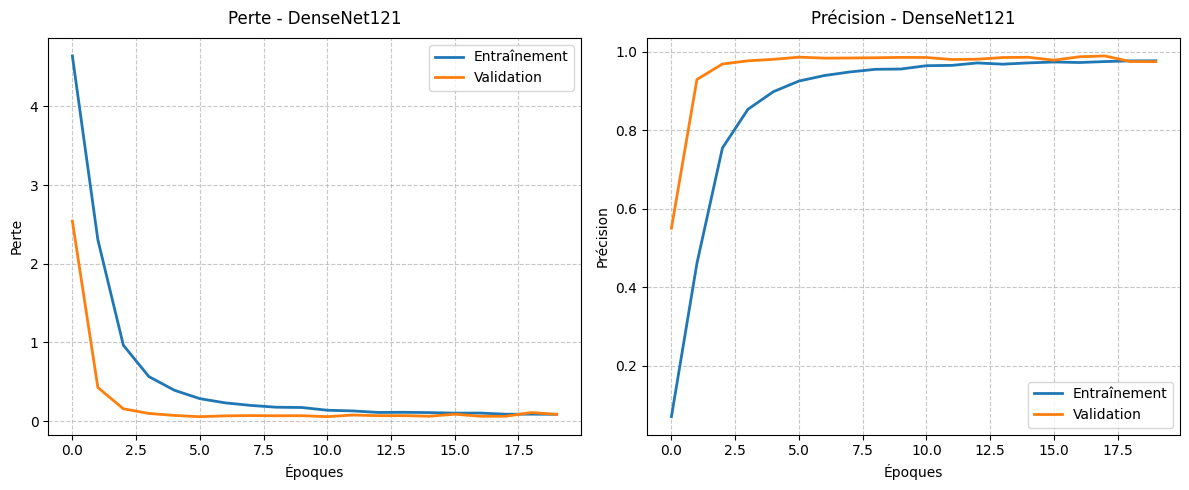

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(history, model_name):
    """
    Trace les courbes d'apprentissage à partir de l'historique d'entraînement.
    
    Args:
        history (dict): Historique d'entraînement contenant loss, accuracy, val_loss, val_accuracy
        model_name (str): Nom du modèle pour les titres
    """
    try:
        plt.style.use('seaborn')  # Changed from 'seaborn-dark' to 'seaborn'
    except:
        print("Warning: Could not load seaborn style, using default style")
    
    plt.figure(figsize=(12, 5))

    # Subplot pour la courbe de perte
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label=f'Entraînement', linewidth=2)
    plt.plot(history['val_loss'], label=f'Validation', linewidth=2)
    plt.title(f'Perte - {model_name}', fontsize=12, pad=10)
    plt.xlabel('Époques', fontsize=10)
    plt.ylabel('Perte', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    # Subplot pour la courbe de précision
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label=f'Entraînement', linewidth=2)
    plt.plot(history['val_accuracy'], label=f'Validation', linewidth=2)
    plt.title(f'Précision - {model_name}', fontsize=12, pad=10)
    plt.xlabel('Époques', fontsize=10)
    plt.ylabel('Précision', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.show()

# Utilisation
plot_training_curves(history, 'DenseNet121')